<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/models/With_MF_ML_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rdkit
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from google.colab import drive
drive.mount('/content/drive')

# Silence some expected warnings
filterwarnings("ignore")

!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/test_mordred_phenol_scaled_reduced.csv
!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/train_mordred_phenol_scaled_reduced.csv
#!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/test_mordred_scaled_reduced.csv
#!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/train_mordred_scaled_reduced.csv
!wget https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/master/models/train_test_datasets/test_mordred_scaled_reduced.csv
!wget https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/master/models/train_test_datasets/train_mordred_scaled_reduced.csv
!wget https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/my_dataframe.csv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 34.7 MB/s eta 0:00:00
Mounted at /content/drive
--2025-05-16 12:46:35--  https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/test_mordred_phenol_scaled_reduced.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-05-16 12:46:36 ERROR 404: Not Found.

--2025-05-16 12:46:36--  https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/train_mordred_phenol_scaled_reduced.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-05-16 12:46:36 ERROR 404: Not Found.

--2025-05-16 12:46:36--  https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/master/models/train_test_datasets/test_mordred_scaled_reduced.csv
Resolving raw

In [3]:
def remove_semi_constant_features(df, semi_constant_threshold):
    """Removes columns from a Pandas DataFrame where 80% or more of the values are the same.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with the single-value columns removed.
    """

    cols_to_drop = []
    for col in df.columns:
        try:
            # Calculate the percentage of the most frequent value
            counts = df[col].value_counts(normalize=True)
            if counts.iloc[0] >= semi_constant_threshold:
                cols_to_drop.append(col)
        except (TypeError, IndexError):
            pass  # Handle cases where value_counts fails (e.g., mixed data types)

    return df.drop(columns=cols_to_drop)

def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df
def drop_high_correlation_columns(df, threshold=0.75):
    """Drops columns from a DataFrame that have a correlation above a specified threshold.

    Args:
        df: The input DataFrame.
        threshold: The correlation threshold above which columns are dropped.

    Returns:
        A new DataFrame with highly correlated columns removed.
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than 0.75
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features
    return df.drop(columns=to_drop)



In [9]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split

# Configuration switches
USE_MORDRED = True       # True for Mordred, False for Morgan
USE_PHENOLS = False       # Filter by is_phenol == 1
FEATURE_SELECTION = True # Only for Mordred

# === Load base data and normalize column names ===
df = pd.read_csv("/content/drive/MyDrive/all_mordred_unscaled_grouped.csv")
df.columns = df.columns.str.strip().str.lower()  # normalize to avoid KeyError
df = df.iloc[:-1]  # Drop last row

# === Load and process data ===
if USE_MORDRED:

    # Drop known non-feature columns
    df = drop_non_numeric_columns(df)
    df = df.dropna(axis=1)

    if USE_PHENOLS and "is_phenol" in df.columns:
        df = df[df["is_phenol"] == 1].copy()

    if FEATURE_SELECTION:
        df = remove_semi_constant_features(df, 0.95)
        df = drop_high_correlation_columns(df, 0.95)

    X = df.drop(columns=["active", "is_phenol"], errors='ignore').to_numpy()
    y = df["active"].to_numpy()

else:
    # Keep only necessary columns for MF
    df = df[["canonical_smiles", "is_phenol", "active"]]

    if USE_PHENOLS and "is_phenol" in df.columns:
        df = df[df["is_phenol"] == 1].copy()

    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

    def smiles_to_fp(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.nan
        return mfpgen.GetFingerprintAsNumPy(mol)

    df["fp"] = df["canonical_smiles"].apply(smiles_to_fp)
    df = df[df["fp"].notna()].copy()

    X = np.vstack(df["fp"].to_numpy())
    y = df["active"].to_numpy()

# === Train-test split ===
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === Construct dynamic filename prefix ===
prefix = []

prefix.append("mordred" if USE_MORDRED else "morgan")
prefix.append("phenol" if USE_PHENOLS else "all")
prefix.append("fs" if FEATURE_SELECTION else "nofs")

basename = "_".join(prefix)

# === Save the train sets ===
pd.DataFrame(X_train).to_csv(f"{basename}_X_train.csv", index=False, header=False)
pd.DataFrame(y_train).to_csv(f"{basename}_y_train.csv", index=False, header=False)
pd.DataFrame(X_test).to_csv(f"{basename}_X_test.csv", index=False, header=False)
pd.DataFrame(y_test).to_csv(f"{basename}_y_test.csv", index=False, header=False)

In [19]:
# Define Preprocessing and Models
from sklearn.metrics import classification_report

def get_model_pipeline(model_name):
    if model_name == 'RandomForest':
        model = RandomForestClassifier(class_weight='balanced', random_state=42)
    elif model_name == 'SVM':
        model = SVC(class_weight='balanced', probability=True, random_state=42)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
    elif model_name == 'NeuralNetwork':
        model = MLPClassifier(max_iter=1000, random_state=42)
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    return pipeline

In [20]:
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__max_features': ['sqrt', 'log2']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    'NeuralNetwork': {
        'classifier__hidden_layer_sizes': [(50,), (100,)],
        'classifier__alpha': [0.0001, 0.001],
        'classifier__learning_rate_init': [0.001, 0.01]
    }
}

In [22]:
#k fold cross validation
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(X_train,y_train)

In [33]:
#Hyperparameter Tuning with Cross-Validation
from sklearn.model_selection import GridSearchCV
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=kf,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return grid_search


In [32]:
# loop through each model, perform grid search, and evaluate

for model_name in ['NeuralNetwork', 'RandomForest', 'LogisticRegression']: #'RandomForest', 'SVM', 'LogisticRegression',
    print(f"\nTraining and evaluating {model_name}...")

    pipeline = get_model_pipeline(model_name)
    param_grid = param_grids[model_name]
    grid_search = perform_grid_search(pipeline, param_grid, X_train, y_train)
    model = grid_search.best_estimator_
    print(f"Hyperparameters: {grid_search.best_params_}\n")




Training and evaluating NeuralNetwork...
Hyperparameters: {'classifier__alpha': 0.0001, 'classifier__early_stopping': True, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate_init': 0.001}


Training and evaluating RandomForest...
Hyperparameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}


Training and evaluating LogisticRegression...
Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}



In [38]:
#Model Evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, f1_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.base import clone

def evaluate_model_with_cv(model, X, y, random_state):
    """
    Evaluate a model using 5-fold cross-validation and return performance metrics.

    Parameters:
        model: The model to evaluate
        X: Feature matrix
        y: Target vector
        random_state: Random seed for reproducibility

    Returns:
        Dictionary with performance metrics and arrays of per-fold metrics
    """
    # Initialize KFold
    kf2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)


    # Lists to store metrics
    metrics = {
        'accuracies': [],
        'f1_scores': [],
        'auc_scores': []
    }

    # Create figure for ROC curves
    plt.figure()

    # Iterate over folds
    for k, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        # Split data
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Train model
        model.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred_fold = model.predict(X_test_fold)
        y_prob_fold = model.predict_proba(X_test_fold)[:, 1]

        # Calculate metrics
        metrics['accuracies'].append(accuracy_score(y_test_fold, y_pred_fold))
        metrics['f1_scores'].append(f1_score(y_test_fold, y_pred_fold))
        metrics['auc_scores'].append(roc_auc_score(y_test_fold, y_prob_fold))

        # ROC curve
        RocCurveDisplay.from_predictions(y_test_fold, y_prob_fold, name=f"Fold {k+1}", ax=plt.gca())

    # Print metrics
    metric_display_names = {
        'accuracies': 'accuracy',
        'f1_scores': 'F1 score',
        'auc_scores': 'AUC score'
    }
    for metric_name, values in metrics.items():
        display_name = metric_display_names[metric_name]
        print(f"Average {display_name}: {np.mean(values):.4f} \t and std err: {stats.sem(values):.4f}")

    return metrics






Training and evaluating NeuralNetwork...
Average accuracy: 0.9495 	 and std err: 0.0153
Average F1 score: 0.9613 	 and std err: 0.0118
Average AUC score: 0.9978 	 and std err: 0.0022

Training and evaluating RandomForest...
Average accuracy: 0.9495 	 and std err: 0.0153
Average F1 score: 0.9613 	 and std err: 0.0118
Average AUC score: 0.9978 	 and std err: 0.0022

Training and evaluating LogisticRegression...
Average accuracy: 0.9495 	 and std err: 0.0153
Average F1 score: 0.9613 	 and std err: 0.0118
Average AUC score: 0.9978 	 and std err: 0.0022


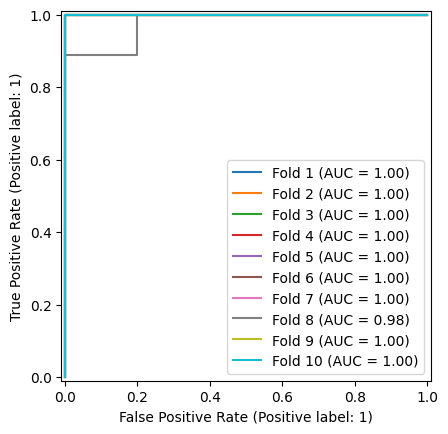

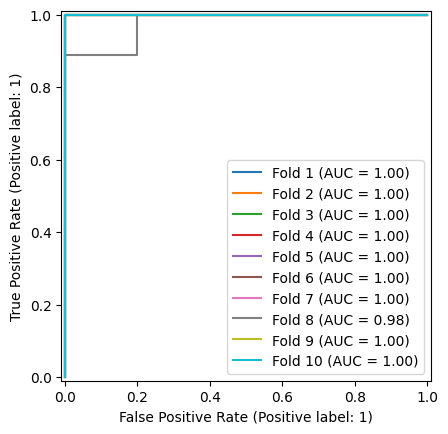

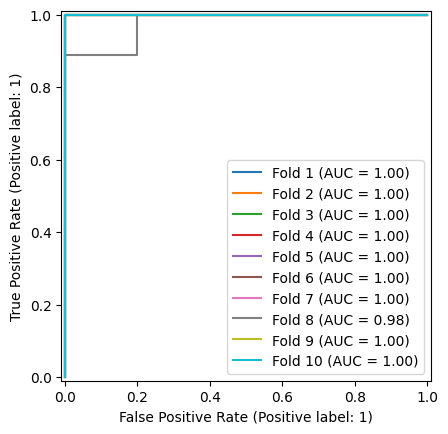

In [39]:
all_metrics = []
for model_name in ['NeuralNetwork', 'RandomForest', 'LogisticRegression']: #'RandomForest', 'SVM', 'LogisticRegression',
    print(f"\nTraining and evaluating {model_name}...")
    metrics = evaluate_model_with_cv(model, X_train, y_train, random_state=42)


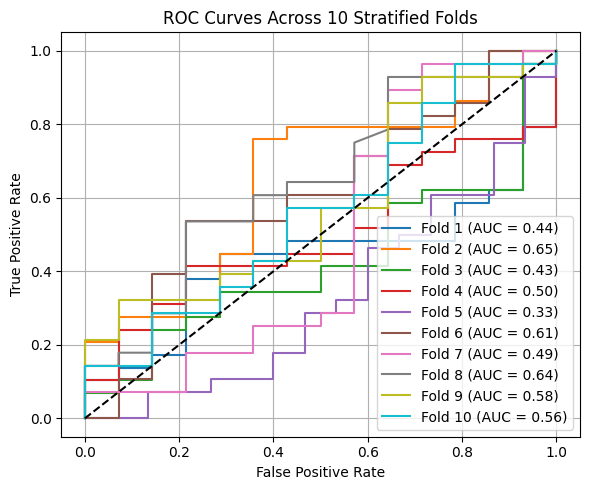


Evaluation Metrics (10-fold Stratified CV):
Accuracies   Mean = 0.5815, StdErr = 0.0257
Precisions   Mean = 0.6823, StdErr = 0.0200
Recalls      Mean = 0.7074, StdErr = 0.0299
F1_scores    Mean = 0.6916, StdErr = 0.0201
Auc_scores   Mean = 0.5237, StdErr = 0.0328
Kappas       Mean = 0.0311, StdErr = 0.0642


{'accuracies': [0.4883720930232558,
  0.6976744186046512,
  0.5581395348837209,
  0.5581395348837209,
  0.46511627906976744,
  0.5952380952380952,
  0.5952380952380952,
  0.7142857142857143,
  0.6190476190476191,
  0.5238095238095238],
 'precisions': [0.6060606060606061,
  0.7857142857142857,
  0.6388888888888888,
  0.6666666666666666,
  0.5806451612903226,
  0.7391304347826086,
  0.7037037037037037,
  0.7352941176470589,
  0.7,
  0.6666666666666666],
 'recalls': [0.6896551724137931,
  0.7586206896551724,
  0.7931034482758621,
  0.6896551724137931,
  0.6428571428571429,
  0.6071428571428571,
  0.6785714285714286,
  0.8928571428571429,
  0.75,
  0.5714285714285714],
 'f1_scores': [0.6451612903225806,
  0.7719298245614035,
  0.7076923076923077,
  0.6779661016949152,
  0.6101694915254238,
  0.6666666666666666,
  0.6909090909090909,
  0.8064516129032258,
  0.7241379310344828,
  0.6153846153846154],
 'auc_scores': [np.float64(0.43596059113300495),
  np.float64(0.6477832512315271),
  np.floa

In [ ]:
# Sanity check 2: random shuffle of y - analog to Ex5 --> looks good
np.random.shuffle(y)
evaluate_model_with_cv(best_model, X, y)



Evaluation Metrics (10-fold Stratified CV):
Accuracies   Mean = 0.6409, StdErr = 0.0146
Precisions   Mean = 0.7673, StdErr = 0.0076
Recalls      Mean = 0.7595, StdErr = 0.0174
F1_scores    Mean = 0.7627, StdErr = 0.0112
Auc_scores   Mean = 0.5000, StdErr = 0.0000
Kappas       Mean = 0.0203, StdErr = 0.0308


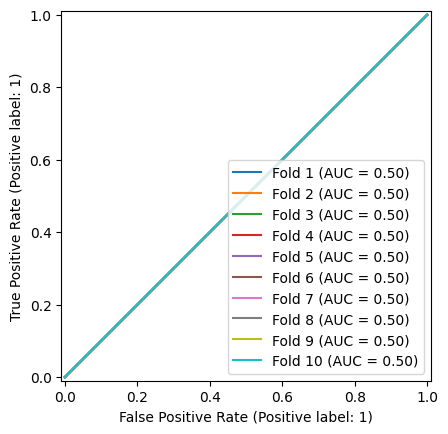

In [ ]:
metrics = evaluate_statistical_classifier(probability=np.mean(y), X=X, y=y, random_state=42)

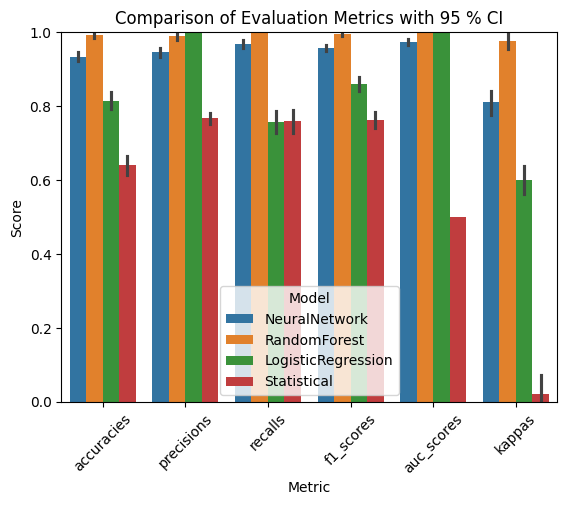

In [ ]:
import seaborn as sns

metrics_melted = metrics_all_models_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model', ci=95)
plt.title("Comparison of Evaluation Metrics with 95 % CI")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()